In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
# Set up paths

path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
path_to_work = '/cw3e/mead/projects/cwp140/scratch/dnash/data/preprocessed/SEAK-WRF-precip/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## choose which option of preprocessed precip
# (a) select the grid cell closest to each of the communities
# (b) select the 9 closest grid cells to each of the communities - take maximum value
# (c) select the 25 closest grid cells to each of the communities- take maximum value
focus = 'impact' # AR, impact, or all
option_lst = ['a', 'b', 'c']*2
temp_lst = ['hourly']*3 + ['daily']*3
df_lst = []
thres_lst = []
tidydf_lst = []

for i, (option, temporal_res) in enumerate(zip(option_lst, temp_lst)):
    fname = path_to_out + 'SEAK_precip_max_{0}_{1}.csv'.format(option, temporal_res)
    df = pd.read_csv(fname)
    df = df.drop(['time'], axis=1) # do not need this for percentiles or box plots
    df = df.replace(0, np.NaN) # replace any instance of zero with nan to ignore dates with no precipitation
    
    if focus == 'AR':
        fname = path_to_out + 'SEAK_ardates_{0}.csv'.format(temporal_res)
        ar_df = pd.read_csv(fname) # read in AR dates
        # append AR dates to current df
        df['AR'] = ar_df.AR
        # select only rows with AR date
        idx = (df.AR > 0)
        df = df.loc[idx]
    elif focus == 'impact':
        fname = path_to_out + 'SEAK_impactdates_{0}.csv'.format(temporal_res)
        impact_df = pd.read_csv(fname) # read in impact dates
        # append impact dates to current df
        df['impact'] = impact_df.IMPACT
        # select only rows with impact date
        idx = (df.impact > 0)
        df = df.loc[idx]
        
    elif focus == 'all':
        print('Considering all dates')
        df = df
        
    df_lst.append(df) # keep raw data
    
    # make df into tidy df
    df_tidy = df.stack().reset_index()
    mapping = {df_tidy.columns[0]:'ID', df_tidy.columns[1]: 'Community', df_tidy.columns[2]:'Precipitation',}
    df_tidy = df_tidy.rename(columns=mapping)
    df_tidy = df_tidy.drop(['ID'], axis=1)
    
    # drop all rows with no precipitation
    df_tidy['option'] = option
    tidydf_lst.append(df_tidy)
    
    ## generate new df with percentiles
    thres = df.describe(percentiles=[.85, .90, .95])
    thres['grid_option'] = option
    thres['temporal_res'] = temporal_res
    thres_lst.append(thres)

In [4]:
## Summarize our percentile threshold findings
## show just 95th percentile but all grid and temporal resolution options
result = pd.concat(thres_lst)
idx = result.index == '95%'
result.loc[idx]

,Hoonah,Skagway,Klukwan,Yakutat,Craig,Kasaan,impact,grid_option,temporal_res
95%,3.91,1.47,2.07,5.71,3.05,3.89,1.00,a,hourly
95%,4.69,1.61,2.39,7.48,3.94,4.82,1.00,b,hourly
95%,5.58,1.77,2.72,8.02,4.72,5.39,1.00,c,hourly
95%,36.96,10.19,28.99,75.86,19.72,30.96,1.00,a,daily
95%,45.46,13.55,30.91,89.52,30.45,37.20,1.00,b,daily
95%,57.94,15.05,37.02,111.94,41.82,42.27,1.00,c,daily


In [5]:
idx = result.index == 'count'
result.loc[idx]

,Hoonah,Skagway,Klukwan,Yakutat,Craig,Kasaan,impact,grid_option,temporal_res
count,"1,184.00",984.00,"1,024.00","1,144.00","1,146.00","1,129.00","4,656.00",a,hourly
count,"1,469.00","1,234.00","1,345.00","1,470.00","1,467.00","1,399.00","4,656.00",b,hourly
count,"1,768.00","1,388.00","1,603.00","1,644.00","1,665.00","1,634.00","4,656.00",c,hourly
count,123.00,109.00,108.00,116.00,118.00,122.00,194.00,a,daily
count,132.00,119.00,118.00,132.00,127.00,130.00,194.00,b,daily
count,138.00,126.00,125.00,140.00,134.00,134.00,194.00,c,daily


In [6]:
## count N for each community exceeding the 95th percentile threshold
n_final = []
for i, df in enumerate(df_lst):
    community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
    n_lst = []
    for j, community in enumerate(community_lst):
        n = len(df[df[community] > df[community].quantile(.95)])
        n_lst.append(n)
    n_final.append(n_lst)
    
# build a df with n to look similar to df above
df2 = pd.DataFrame(np.array(n_final),
                   columns=community_lst)

df2['grid_option'] = option_lst
df2['temporal_res'] = temp_lst
df2

,Hoonah,Skagway,Klukwan,Yakutat,Craig,Kasaan,grid_option,temporal_res
0,60,50,52,58,58,57,a,hourly
1,74,62,68,74,74,70,b,hourly
2,89,70,81,83,84,82,c,hourly
3,7,6,6,6,6,7,a,daily
4,7,6,6,7,7,7,b,daily
5,7,7,7,7,7,7,c,daily


In [7]:
hourly_df = pd.concat(tidydf_lst[0:3])
daily_df = pd.concat(tidydf_lst[3:])

## Plot box plots of precipitation data

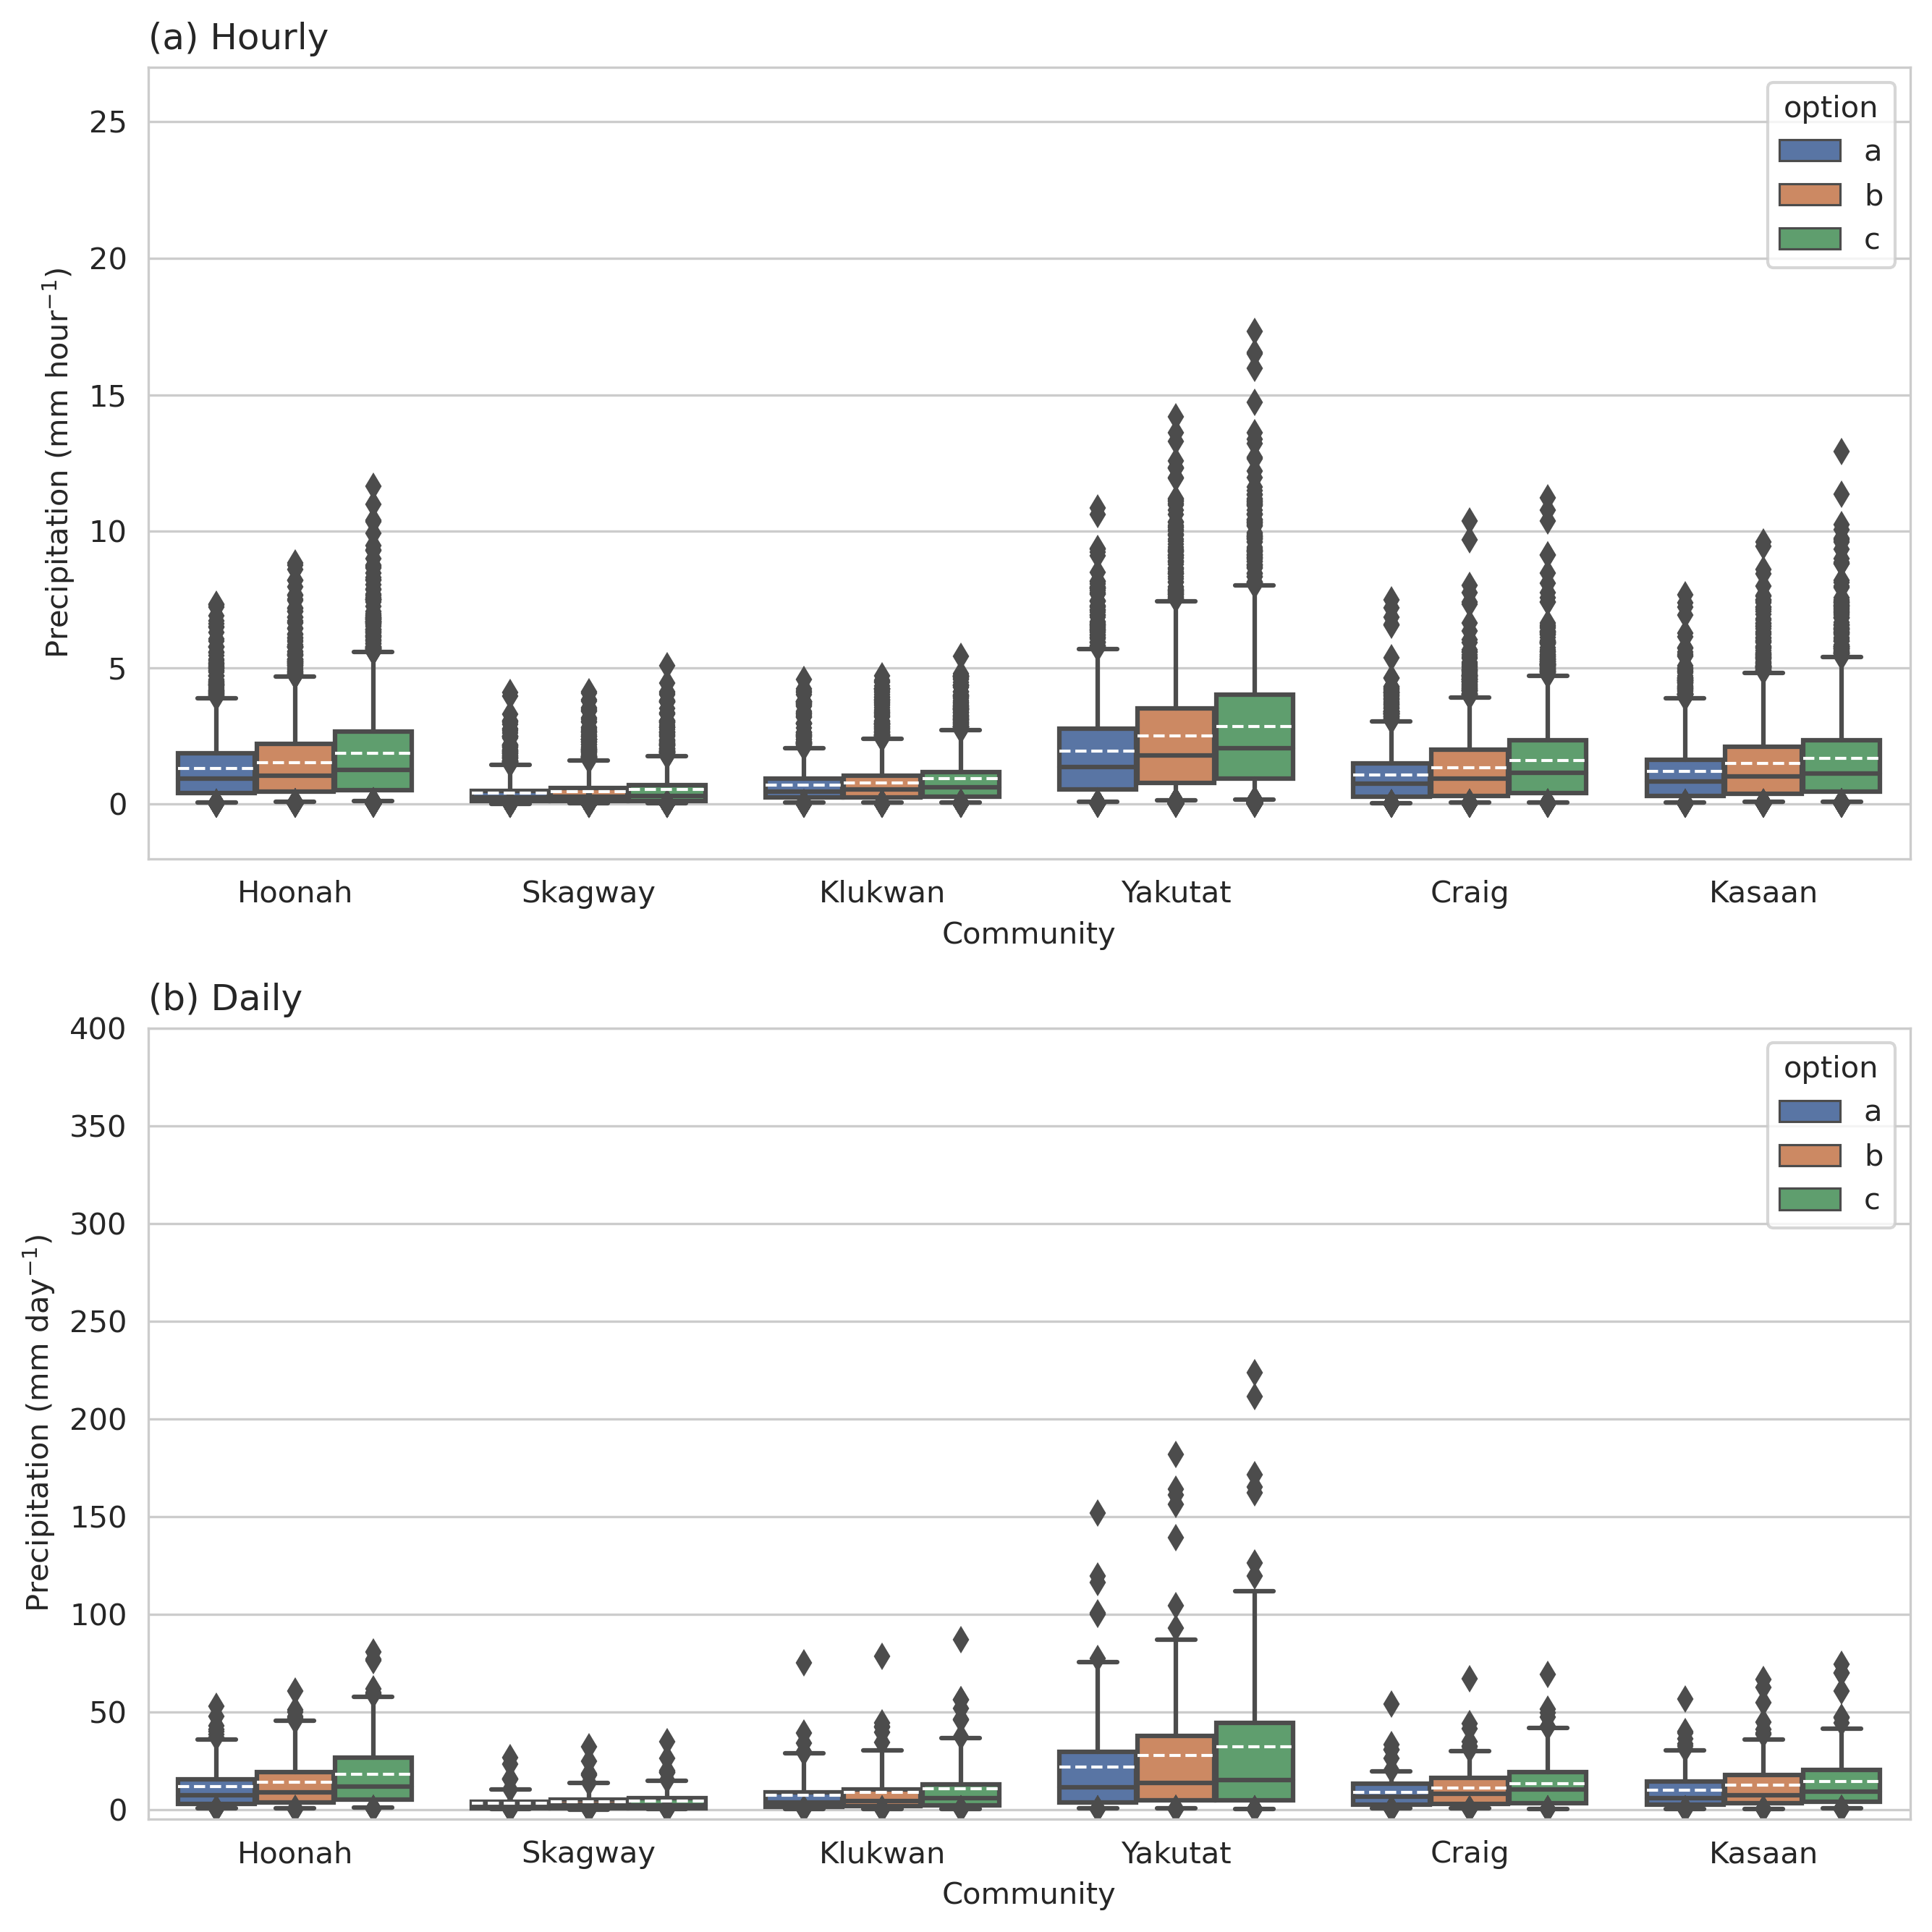

In [8]:
fname = path_to_figs + 'boxplot_{0}-days'.format(focus)

fmt = 'png'
fig = plt.figure()
fig.set_size_inches((9.,9.0))
fig.dpi = 300
nrows = 2
ncols = 1
nplots=nrows*ncols

plt_lbl = ['(a) Hourly', '(b) Daily']
units = ['mm hour$^{-1}$'] + ['mm day$^{-1}$']

for i, df in enumerate([hourly_df, daily_df]):
    sns.set_style("whitegrid")
    ax = plt.subplot(nrows, ncols, i+1)

    g = sns.boxplot(x="Community", y="Precipitation", hue='option', data=df, palette='deep', whis=[5, 95],
                    order=community_lst,
                    meanline=True, showmeans=True, meanprops={'c':'white', 'lw':1})
    
    
    sns.set_style("ticks")
    if i == 0:
        plt.ylim(-2, 27)
    elif i == 1:
        plt.ylim(-5, 400)
    
    ax.set_title(plt_lbl[i], loc='left')
    # ax.annotate(plt_lbl[i], (5, 207), xycoords='axes points', fontsize=12.,
    #         backgroundcolor='white', zorder=100)
        
    ax.set_ylabel('Precipitation ({0})'.format(units[i]))
    ax.set_xlabel('Community')
    
    if i < 0:
        g.legend_.remove()
    

plt.tight_layout()
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
plt.show()



In [9]:

# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# # Initialize the FacetGrid object
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(data, row="g", hue="g", aspect=15, height=.5, palette=pal)

# # Draw the densities in a few steps
# g.map(sns.kdeplot, "x",
#       bw_adjust=.5, clip_on=False,
#       fill=True, alpha=1, linewidth=1.5)
# g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# # passing color=None to refline() uses the hue mapping
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# # Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color,
#             ha="left", va="center", transform=ax.transAxes)


# g.map(label, "x")

# # Set the subplots to overlap
# g.figure.subplots_adjust(hspace=-.25)

# # Remove axes details that don't play well with overlap
# g.set_titles("")
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)